# Intra-Cluster Light (ICL) profiles analysis in the Dark Energy Survey (DES)




In [1]:
import healpy as hp
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from healpy.rotator import Rotator
import kmeans_radec
from kmeans_radec import KMeans, kmeans_sample
import os
import os.path
import configparser
import sys
from astropy.table import Table
import uncertainties

/home/hillysson/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
ini_file= 'redmapper_y1.ini'
config = configparser.ConfigParser()
inifile = config.read(ini_file)
input_dir_rdmp=config.get('input', 'input_dir')
catalog=config.get('input', 'catalog_file')
flag_files_rdmp=[ii.strip() for ii in config.get('input', 'flag_files').split(',')]
save_dir_rdmp=config.get('output', 'save_dir')
grid_output_dir_rdmp=config.get('grid_output', 'save_dir')
rdmp=pyfits.open(catalog)[1].data
flags_rdmp=np.zeros(len(rdmp))+1
indices_rdmp=np.arange(len(rdmp))

### ICL jacknife profiles subtraction

In [3]:
str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']
richness_dir = ['richness_20_30/',
                'richness_30_45/',
                'richness_45_60/',
                'richness_60_beyond/']

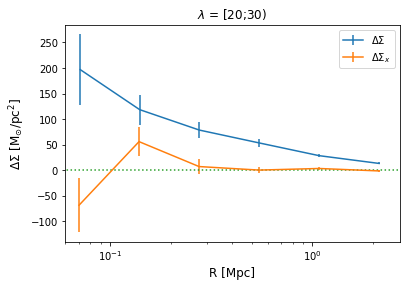

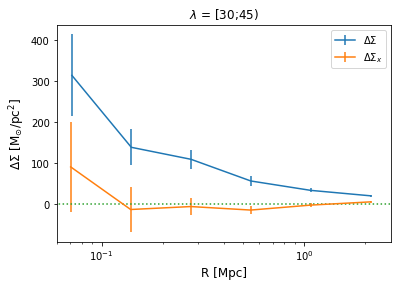

In [6]:
str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']
colors = ['C2','C1','C3','C4']


for i in range(4):

    # covariance for dsigma
    cov = np.load(wl_prefix+ wl_dir[i]+'cov.npy')
    # covariance for dsigmax
    covx = np.load(wl_prefix+ wl_dir[i]+'covx.npy')
    # DeltaSigma
    dsigma = np.load(wl_prefix+ wl_dir[i]+'dsigma.npy')
    # DeltaSigma_x (cross component)
    dsigmax = np.load(wl_prefix+ wl_dir[i]+'dsigmax.npy')

    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])

    plt.xscale('log')
    #plt.yscale('log')

    #l=uncertainties.correlated_values(dsigma, cov)
    #erro = [i.s for i in l]
    #lx=uncertainties.correlated_values(dsigmax, covx)
    #errox = [i.s for i in lx]
    erro = np.sqrt(np.diagonal(cov))
    errox = np.sqrt(np.diagonal(covx))

    plt.errorbar(Rmid+0.001,dsigma, yerr=np.array(erro), label='$\Delta \Sigma$')
    plt.errorbar(Rmid,dsigmax, yerr=np.array(errox), label='$\Delta \Sigma_{x}$')
    plt.plot([0.01,2000], [0,0], ':')
    plt.xlim(0.06, 2.7)
    plt.xlabel('R [Mpc]', fontsize=12)
    plt.ylabel('$\Delta \Sigma$ [M$_{\odot}$/pc$^{2}$]', fontsize=12)
    plt.title(str(str_ngals[i]), fontsize=12)
    plt.legend()
    plt.show()

/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


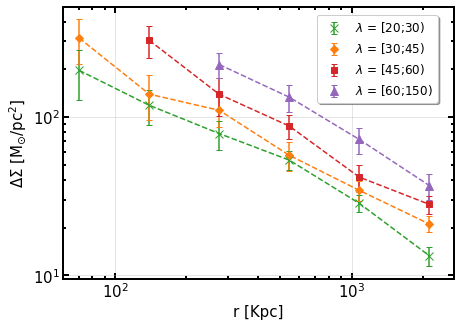

In [7]:
str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;150)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']
symbols = ['x', 'D', 's','^','o', ]
symbolsize = ['8','5','6','8','8']

fig = plt.figure(figsize=(7,5))  
ax = plt.subplot()
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.4)


for i in range(4):

    # covariance for dsigma
    cov = np.load(wl_prefix+ wl_dir[i]+'cov.npy')
    # covariance for dsigmax
    covx = np.load(wl_prefix+ wl_dir[i]+'covx.npy')
    # DeltaSigma
    dsigma = np.load(wl_prefix+ wl_dir[i]+'dsigma.npy')
    # DeltaSigma_x (cross component)
    dsigmax = np.load(wl_prefix+ wl_dir[i]+'dsigmax.npy')

    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])

    plt.xscale('log')
    #plt.yscale('log')

    erro = np.sqrt(np.diagonal(cov))
    errox = np.sqrt(np.diagonal(covx))
    
    # for some subsets the first bins are not trustable due to the BCG interference
    trustable  = [0,0,0.1, 0.2]
    mask = Rmid > trustable[i]

    plt.errorbar(Rmid[mask]*1000,dsigma[mask], yerr=np.array(erro)[mask], color=colors[i], 
                 label=str(str_ngals[i]), fmt=symbols[i],markersize=symbolsize[i], capsize=3)
    plt.plot(Rmid[mask]*1000,dsigma[mask],'--', color=colors[i])
    #plt.errorbar(Rmid,dsigmax, yerr=np.array(errox), l color=colors[i],abel='$\Delta \Sigma_{x}$')
plt.plot([0.01,3000], [0,0], ':')
plt.xlim(60, 2700)
plt.xlabel('r [Kpc]', fontsize=15)
plt.ylabel('$\Delta \Sigma$ [M$_{\odot}$/pc$^{2}$]', fontsize=15)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)

plt.legend(bbox_to_anchor=(0.65, 0.97),  loc=2, fontsize=12,borderaxespad=0.,
           numpoints=1,scatterpoints=1,frameon=True, shadow=True)

plt.savefig(save_dir_rdmp+'paper_figures/'+'wl.png', format='png', dpi=300)
plt.show()

/home/hillysson/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


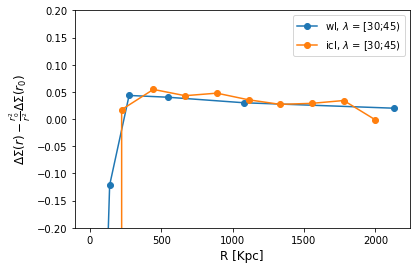

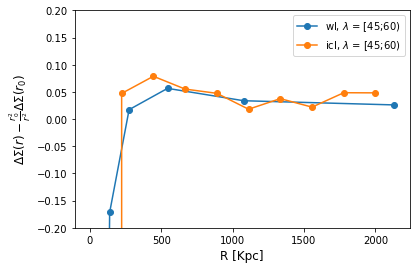

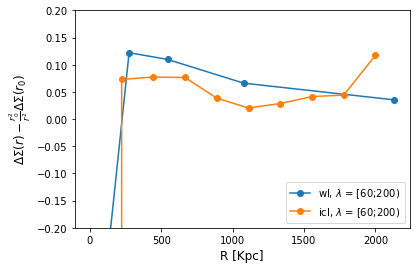

In [6]:
def delta_deltax(rad, delta, r0=200):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

from scipy.interpolate import interp1d

for i in range(4):

    
    ########################################
    #  Weak lensing
    
    # covariance for dsigma
    cov = np.load(wl_prefix+ wl_dir[i]+'cov.npy')
    # covariance for dsigmax
    covx = np.load(wl_prefix+ wl_dir[i]+'covx.npy')
    # DeltaSigma
    dsigma = np.load(wl_prefix+ wl_dir[i]+'dsigma.npy')
    # DeltaSigma_x (cross component)
    dsigmax = np.load(wl_prefix+ wl_dir[i]+'dsigmax.npy')

    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])

    erro_up = dsigma+np.sqrt(np.diagonal(cov))
    erro_low = dsigma-np.sqrt(np.diagonal(cov))
    
    delta_wl = delta_deltax(Rmid*1000, dsigma, r0=200)
    delta_wl_up = delta_deltax(Rmid*1000, erro_up, r0=200)
    delta_wl_low = delta_deltax(Rmid*1000, erro_low, r0=200)
    
    ########################################
    #  ICL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;200)'] 
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    delta_icl_ = first_delta_icl(r_red, mea)
    delt_icl = delta_deltax(r_red, delta_icl_, r0=200)
    func=interp1d(r_red, delt_icl, fill_value = 'extrapolate')
    rmid = np.linspace(1,2001, 10)
    delta_icl2=func(rmid)  
    
    #r_red_, delta_icl_ = delta_delta_icl(r_red, mea, r0=200)
    #func=interp1d(r_red_, delta_icl_, fill_value = 'extrapolate')
    #delta_icl=func(Rmid*1000)  
    
    
    ########################################
    
    #plt.xscale('log')
    
    #plt.fill_between(Rmid*1000, delta_wl_up, delta_wl_low, alpha=0.15, label='')
    plt.plot(Rmid*1000, delta_wl/1000, 'o-',label='wl, '+str_ngals[i])
    #plt.plot(Rmid*1000, delta_icl, 'o-',label='icl, '+str_ngals[i])
    plt.plot(rmid, delta_icl2, 'o-',label='icl, '+str_ngals[i])
    #plt.plot([0.01,2000], [0,0], ':')
    #plt.xlim(0.06, 2.7)
    plt.ylim(-0.2, 0.2)
    plt.xlabel('R [Kpc]', fontsize=12)
    plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=12)
    plt.legend()
    plt.show()

[1277.45150416 1831.37139235]
1554.4114482539612


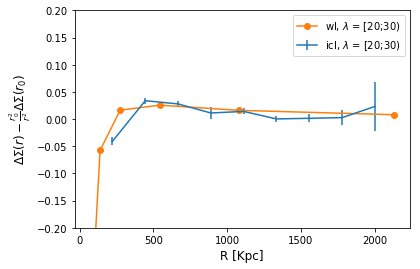

[1064.34853778  876.89140373]
970.6199707591293


[1226.54078861 1941.4945268 ]
1584.0176577042434


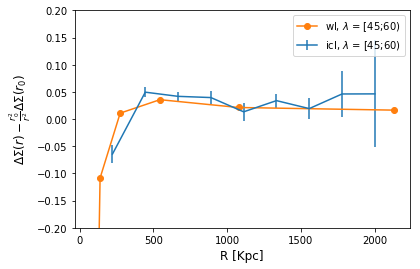

[1989.23329418 3594.5095547 ]
2791.8714244365838


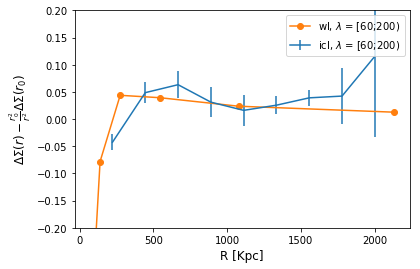

In [7]:
def delta_deltax(rad, delta, r0=200):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

from scipy.interpolate import interp1d

for i in range(4):

    
    ########################################
    #  Weak lensing
    
    # covariance for dsigma
    cov = np.load(wl_prefix+ wl_dir[i]+'cov.npy')
    # covariance for dsigmax
    covx = np.load(wl_prefix+ wl_dir[i]+'covx.npy')
    # DeltaSigma
    dsigma = np.load(wl_prefix+ wl_dir[i]+'dsigma.npy')
    # DeltaSigma_x (cross component)
    dsigmax = np.load(wl_prefix+ wl_dir[i]+'dsigmax.npy')

    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])

    erro_up = dsigma+np.sqrt(np.diagonal(cov))
    erro_low = dsigma-np.sqrt(np.diagonal(cov))
    
    delta_wl = delta_deltax(Rmid*1000, dsigma, r0=200)
    delta_wl_up = delta_deltax(Rmid*1000, erro_up, r0=200)
    delta_wl_low = delta_deltax(Rmid*1000, erro_low, r0=200)
    
    ########################################
    #  ICL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;200)'] 
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'delta_moments.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    up = mea+std
    low = mea-std
    
    func=interp1d(r_red, mea, fill_value = 'extrapolate')
    yy_arr=func(Rmid*1000)  
    
    
    ########################################

    #plt.plot(Rmid*1000, delta_wl/yy_arr, 'o-',label='wl/icl, '+str_ngals[i])
    
    ########################################
    
    #plt.xscale('log')
    
    
    print(np.array(delta_wl/yy_arr)[3:5])
    print(np.median(np.array(delta_wl/yy_arr)[3:5]))
    
    ffactor = np.median(np.array(delta_wl/yy_arr)[3:5])
    

    #plt.plot(Rmid*1000, delta_wl/1000, 'o-',label='wl, '+str_ngals[i])
    plt.errorbar(r_red, mea, yerr=np.array(std), label='icl, '+str_ngals[i])
    #plt.plot(Rmid*1000, yy_arr, 'o-',label='wl, '+str_ngals[i])
    #plt.plot(Rmid*1000, delta_wl/yy_arr, 'o-',label='wl, '+str_ngals[i])
    plt.plot(Rmid*1000, delta_wl/ffactor, 'o-',label='wl, '+str_ngals[i])
    

    
    
    plt.ylim(-0.2, 0.2)
    #plt.ylim(-20, 100)
    plt.xlabel('R [Kpc]', fontsize=12)
    plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=12)
    plt.legend()
    plt.show()

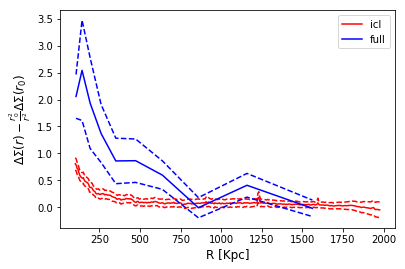

In [8]:
def delta_deltax(rad, delta, r0=200.):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200.
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200.):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200.):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

from scipy.interpolate import interp1d

for i in range(4):
    
    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])
    

    #  ICL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;200)'] 
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    
    ########################################
    
    
    #  full image
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments_unmasked.txt')
    r_red_1, mea_1, std_1= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    
    ########################################
    
    mask = r_red > 100.
    mask_1 = r_red_1 > 100.
    
    plt.plot(r_red[mask], mea[mask], '-',color='red',label='icl')
    #plt.errorbar(r_red[mask], mea[mask], yerr=np.array(std[mask]), fmt='.', color='red', 
    #             label='full, '+str_ngals[i])
    plt.plot(r_red[mask], mea[mask]+np.array(std[mask]), '--',color='red',label='')
    plt.plot(r_red[mask], mea[mask]-np.array(std[mask]), '--',color='red',label='')
 
    plt.plot(r_red_1[mask_1], mea_1[mask_1], '-',color='blue', label='full')    
    #plt.errorbar(r_red_1[mask_1], mea_1[mask_1], yerr=np.array(std_1[mask_1]), fmt='.', 
    #             color='blue', label='full, '+str_ngals[i])
    plt.plot(r_red_1[mask_1], mea_1[mask_1]+np.array(std_1[mask_1]), '--',color='blue', label='')   
    plt.plot(r_red_1[mask_1], mea_1[mask_1]-np.array(std_1[mask_1]), '--',color='blue', label='')   

    
    #plt.plot([0.01,2000], [0,0], ':')
    #plt.xlim(0.06, 2.7)
    #plt.ylim(-0.2, 0.2)
    plt.xlabel('R [Kpc]', fontsize=12)
    plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=12)
    plt.legend()
    plt.show()

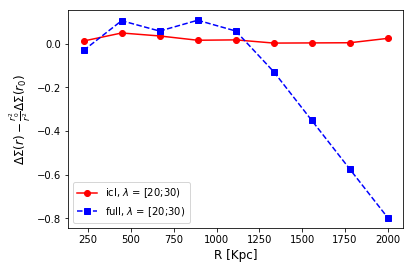

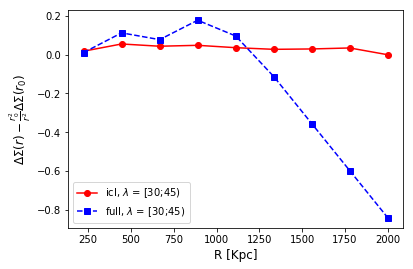

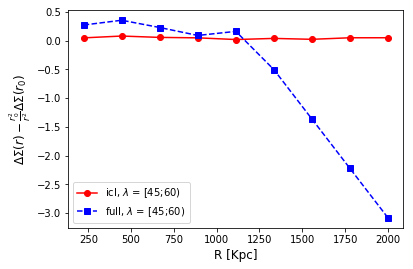

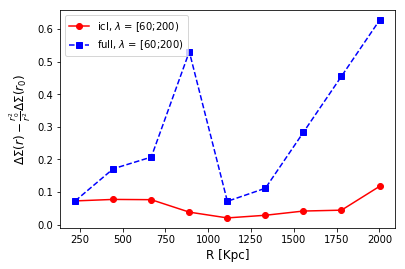

In [9]:
def delta_deltax(rad, delta, r0=200.):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200.
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200.):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200.):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

from scipy.interpolate import interp1d

for i in range(4):
    
    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])
    

    #  ICL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;200)'] 
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    delta_icl_ = first_delta_icl(r_red, mea)
    delt_icl = delta_deltax(r_red, delta_icl_, r0=200.)
    func=interp1d(r_red, delt_icl, fill_value = 'extrapolate')
    rmid = np.linspace(1,2001, 10)
    delta_icl2=func(rmid)  
    
    
    ########################################
    
    
    #  full image
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments_unmasked.txt')
    r_red_1, mea_1, std_1= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    delta_icl_1_ = first_delta_icl(r_red_1, mea_1)
    delt_icl_1 = delta_deltax(r_red_1, delta_icl_1_, r0=200.)
    func=interp1d(r_red_1, delt_icl_1, fill_value = 'extrapolate')
    rmid = np.linspace(1,2001, 10)
    delta_icl2_1=func(rmid)  
    
    ########################################
    
    mask = rmid> 100.
    
    plt.plot(rmid[mask], delta_icl2[mask], 'o-',color='red',label='icl, '+str_ngals[i])
    plt.plot(rmid[mask], delta_icl2_1[mask], 's--',color='blue', label='full, '+str_ngals[i])
    #plt.plot([0.01,2000], [0,0], ':')
    #plt.xlim(0.06, 2.7)
    #plt.ylim(-0.2, 0.2)
    plt.xlabel('R [Kpc]', fontsize=12)
    plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=12)
    plt.legend()
    plt.show()

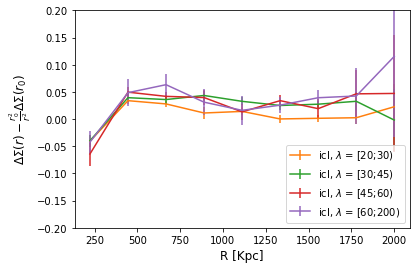

In [10]:
def delta_deltax(rad, delta, r0=200):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

from scipy.interpolate import interp1d

for i in range(4):

    
    ########################################
    #  Weak lensing
    
    # covariance for dsigma
    cov = np.load(wl_prefix+ wl_dir[i]+'cov.npy')
    # covariance for dsigmax
    covx = np.load(wl_prefix+ wl_dir[i]+'covx.npy')
    # DeltaSigma
    dsigma = np.load(wl_prefix+ wl_dir[i]+'dsigma.npy')
    # DeltaSigma_x (cross component)
    dsigmax = np.load(wl_prefix+ wl_dir[i]+'dsigmax.npy')

    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])

    erro_up = dsigma+np.sqrt(np.diagonal(cov))
    erro_low = dsigma-np.sqrt(np.diagonal(cov))
    
    delta_wl = delta_deltax(Rmid*1000, dsigma, r0=200)
    delta_wl_up = delta_deltax(Rmid*1000, erro_up, r0=200)
    delta_wl_low = delta_deltax(Rmid*1000, erro_low, r0=200)
    
    ########################################
    #  ICL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;200)']  
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'delta_moments.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    up = mea+std
    low = mea-std
    ########################################
    
    #plt.xscale('log')
    
    #plt.fill_between(Rmid*1000, delta_wl_up, delta_wl_low, alpha=0.15, label='')
    #plt.plot(Rmid*1000, delta_wl/1000, 'o-',label='wl, '+str_ngals[i])
    plt.errorbar(r_red, mea, yerr=np.array(std), color=colors[i],label='icl, '+str_ngals[i])
    #plt.plot([0.01,2000], [0,0], ':')
    #plt.xlim(0.06, 2.7)
plt.ylim(-0.2, 0.2)
#plt.ylim(-20, 100)
plt.xlabel('R [Kpc]', fontsize=12)
plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=12)
plt.legend()
plt.show()

/home/hillysson/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3157: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


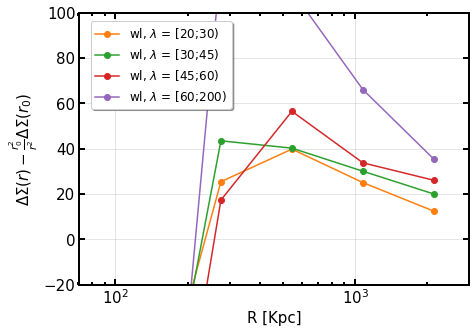

In [11]:
def delta_deltax(rad, delta, r0=200):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

from scipy.interpolate import interp1d

fig = plt.figure(figsize=(7,5))  
ax = plt.subplot()
plt.xscale('log')
#plt.yscale('log')
plt.grid(alpha=0.4)

for i in range(4):

    
    ########################################
    #  Weak lensing
    
    # covariance for dsigma
    cov = np.load(wl_prefix+ wl_dir[i]+'cov.npy')
    # covariance for dsigmax
    covx = np.load(wl_prefix+ wl_dir[i]+'covx.npy')
    # DeltaSigma
    dsigma = np.load(wl_prefix+ wl_dir[i]+'dsigma.npy')
    # DeltaSigma_x (cross component)
    dsigmax = np.load(wl_prefix+ wl_dir[i]+'dsigmax.npy')

    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])

    erro_up = dsigma+np.sqrt(np.diagonal(cov))
    erro_low = dsigma-np.sqrt(np.diagonal(cov))
    
    delta_wl = delta_deltax(Rmid*1000, dsigma, r0=200)
    delta_wl_up = delta_deltax(Rmid*1000, erro_up, r0=200)
    delta_wl_low = delta_deltax(Rmid*1000, erro_low, r0=200)
    
    ########################################
    #  ICL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']   
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'delta_moments.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    up = mea+std
    low = mea-std
    ########################################
    
    #plt.xscale('log')
    
    #plt.fill_between(Rmid*1000, delta_wl_up, delta_wl_low, alpha=0.15, label='')
    plt.plot(Rmid*1000, delta_wl, 'o-',color=colors[i],label='wl, '+str_ngals[i])
    #plt.errorbar(r_red, mea, yerr=np.array(std), color=colors[i],label='icl, '+str_ngals[i])
    #plt.plot([0.01,2000], [0,0], ':')
    #plt.xlim(0.06, 2.7)
#plt.ylim(-0.2, 0.2)
plt.ylim(-20, 100)
plt.xlim(-100, 3000)
plt.xlabel('R [Kpc]', fontsize=15)
plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=15)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)

plt.legend(bbox_to_anchor=(0.03, 0.97),  loc=2, fontsize=12,borderaxespad=0.,
           numpoints=1,scatterpoints=1,frameon=True, shadow=True)
plt.show()

[1277.4515041568432, 1831.371392351079]
1554.4114482539612
 
[1064.3485377838858, 876.8914037343726]
970.6199707591293
 
[1226.5407886062217, 1941.4945268022655]
1584.0176577042434
 
[1989.2332941778004, 3594.5095546953667]
2791.8714244365838
 


/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


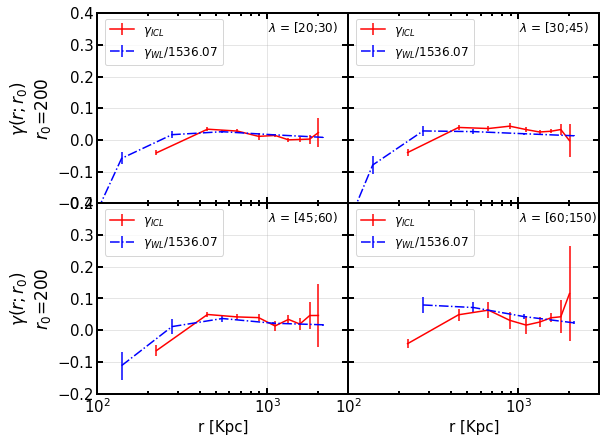

In [33]:
def delta_deltax(rad, delta, r0=200.):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200.
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200.):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200.):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

from scipy.interpolate import interp1d

fig = plt.figure(figsize=(9,7))  

qvalues = []

for i in range(4):
    
    ax = plt.subplot(2,2,i+1)
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid(alpha=0.4)

    
    ########################################
    #  Weak lensing
    
    # covariance for dsigma
    cov = np.load(wl_prefix+ wl_dir[i]+'cov.npy')
    # covariance for dsigmax
    covx = np.load(wl_prefix+ wl_dir[i]+'covx.npy')
    # DeltaSigma
    dsigma = np.load(wl_prefix+ wl_dir[i]+'dsigma.npy')
    # DeltaSigma_x (cross component)
    dsigmax = np.load(wl_prefix+ wl_dir[i]+'dsigmax.npy')

    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])

    #erro_up = dsigma+np.sqrt(np.diagonal(cov))
    #erro_low = dsigma-np.sqrt(np.diagonal(cov))
    erro_wl = np.sqrt(np.diagonal(cov))
    
    delta_wl = delta_deltax(Rmid*1000, dsigma, r0=200.)
    #delta_wl_up = delta_deltax(Rmid*1000, erro_up, r0=200.)
    #delta_wl_low = delta_deltax(Rmid*1000, erro_low, r0=200.)
    
    
    
    
    ########################################
    #  ICL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;150)']   
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'delta_moments.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    up = mea+std
    low = mea-std
    ########################################
    
    func=interp1d(r_red, mea, fill_value = 'extrapolate')
    yy_arr=func(Rmid*1000) 
    
    ffactor = np.mean(np.array(delta_wl/yy_arr)[3:5])
    qvalues.append(list(delta_wl/yy_arr)[3:5])
    print(list(delta_wl/yy_arr)[3:5])
    print(ffactor)
    print(' ')
    ffactor = 1536.0733043172847
    
    
    trustable  = [0,0,0.1, 0.2]
    mask = Rmid > trustable[i]
    
    plt.errorbar(r_red, mea, yerr=np.array(std),color='red', label='$\gamma_{ICL}$')
    #plt.plot((Rmid*1000)[mask], (delta_wl/ffactor)[mask], 'o-',color='blue',label='$\gamma_{WL}$/%.2f'%(ffactor))
    
    std_wl = (erro_wl/ffactor)[mask]
    plt.errorbar((Rmid*1000)[mask], (delta_wl/ffactor)[mask], 
                 yerr=np.array(std_wl),linestyle='dashdot',color='blue',label='$\gamma_{WL}$/%.2f'%(ffactor))

    
    plt.ylim(-0.2, 0.4)
    plt.xlim(100, 3000)
    plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
                   bottom='on', top='on', left='on', right ='on')
    plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
                   bottom='on', top='on', left='on', right ='on')
    plt.yticks(fontsize=0)
    plt.xticks(fontsize=0)
    [ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.legend(bbox_to_anchor=(0.03, 0.97),  loc=2, fontsize=12,borderaxespad=0.,
               numpoints=1,scatterpoints=1)
    
    plt.annotate(str_ngals[i],
                 xy=(0.68,0.9),xycoords='axes fraction',
                 fontsize=12)
    #plt.annotate('$q$ = %.2f'%(ffactor),
    #             xy=(0.03,0.63),xycoords='axes fraction',
    #             fontsize=12)
    

plt.subplot(2,2,1)  
plt.ylabel(r'$\gamma (r;r_{0})$'+'\n'+'$r_{0}$=200', fontsize=17)
plt.yticks(fontsize = 15)

plt.subplot(2,2,3)  
plt.xlabel('r [Kpc]', fontsize=15)
plt.ylabel(r'$\gamma (r;r_{0})$'+'\n'+'$r_{0}$=200', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.subplot(2,2,4)  
plt.xlabel('r [Kpc]', fontsize=15) 
plt.xticks(fontsize = 15)

plt.savefig(save_dir_rdmp+'paper_figures/'+'icl_wl.png', format='png', dpi=300)
plt.show()

[482.5251078229803, 430.3032576772337]
456.414182750107
 
[465.9266009947411, 345.57647360587544]
405.75153730030826
 
[255.0814411499953, 258.36348472737]
256.72246293868267
 
[592.2133526434143, 662.8634398241444]
627.5383962337794
 


/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


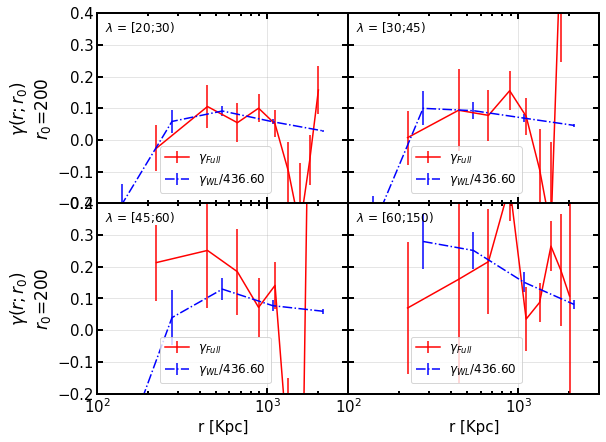

In [32]:
def delta_deltax(rad, delta, r0=200.):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200.
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200.):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200.):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

from scipy.interpolate import interp1d

fig = plt.figure(figsize=(9,7))  

qvalues = []

for i in range(4):
    
    ax = plt.subplot(2,2,i+1)
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid(alpha=0.4)

    
    ########################################
    #  Weak lensing
    
    # covariance for dsigma
    cov = np.load(wl_prefix+ wl_dir[i]+'cov.npy')
    # covariance for dsigmax
    covx = np.load(wl_prefix+ wl_dir[i]+'covx.npy')
    # DeltaSigma
    dsigma = np.load(wl_prefix+ wl_dir[i]+'dsigma.npy')
    # DeltaSigma_x (cross component)
    dsigmax = np.load(wl_prefix+ wl_dir[i]+'dsigmax.npy')

    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])

    #erro_up = dsigma+np.sqrt(np.diagonal(cov))
    #erro_low = dsigma-np.sqrt(np.diagonal(cov))
    erro_wl = np.sqrt(np.diagonal(cov))
    
    delta_wl = delta_deltax(Rmid*1000, dsigma, r0=200.)
    #delta_wl_up = delta_deltax(Rmid*1000, erro_up, r0=200.)
    #delta_wl_low = delta_deltax(Rmid*1000, erro_low, r0=200.)
    
    
    
    
    ########################################
    #  FULL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;150)']   
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'delta_moments_unmasked.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    up = mea+std
    low = mea-std
    ########################################

    func=interp1d(r_red, mea, fill_value = 'extrapolate')
    yy_arr=func(Rmid*1000) 
    
    ffactor = np.mean(np.array(delta_wl/yy_arr)[3:5])
    qvalues.append(list(delta_wl/yy_arr)[3:5])
    print(list(delta_wl/yy_arr)[3:5])
    print(ffactor)
    print(' ')
    ffactor = 436.60
    
    
    trustable  = [0,0,0.1, 0.2]
    mask = Rmid > trustable[i]
    
    plt.errorbar(r_red, mea, yerr=np.array(std),color='red', label='$\gamma_{Full}$')
    #plt.plot((Rmid*1000)[mask], (delta_wl/ffactor)[mask], 'o-',color='blue',label='$\gamma_{WL}$/%.2f'%(ffactor))
    
    std_wl = (erro_wl/ffactor)[mask]
    plt.errorbar((Rmid*1000)[mask], (delta_wl/ffactor)[mask], 
                 yerr=np.array(std_wl),linestyle='dashdot',color='blue',label='$\gamma_{WL}$/%.2f'%(ffactor))
    
    
    
    
    plt.ylim(-0.2, 0.4)
    plt.xlim(100, 3000)
    plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
                   bottom='on', top='on', left='on', right ='on')
    plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
                   bottom='on', top='on', left='on', right ='on')
    plt.yticks(fontsize=0)
    plt.xticks(fontsize=0)
    [ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.legend(bbox_to_anchor=(0.25, 0.3),  loc=2, fontsize=12,borderaxespad=0.,
               numpoints=1,scatterpoints=1)
    
    plt.annotate(str_ngals[i],
                 xy=(0.03,0.9),xycoords='axes fraction',
                 fontsize=12)
    #plt.annotate('$q$ = %.2f'%(ffactor),
    #             xy=(0.03,0.63),xycoords='axes fraction',
    #             fontsize=12)
    

plt.subplot(2,2,1)  
plt.ylabel(r'$\gamma (r;r_{0})$'+'\n'+'$r_{0}$=200', fontsize=17)
plt.yticks(fontsize = 15)

plt.subplot(2,2,3)  
plt.xlabel('r [Kpc]', fontsize=15)
plt.ylabel(r'$\gamma (r;r_{0})$'+'\n'+'$r_{0}$=200', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.subplot(2,2,4)  
plt.xlabel('r [Kpc]', fontsize=15) 
plt.xticks(fontsize = 15)

plt.savefig(save_dir_rdmp+'paper_figures/'+'full_wl.png', format='png', dpi=300)
plt.show()

In [13]:
(1417.2325659288833+819.5109670525944+1496.2065756027064+2411.3431086849546)/4

1536.0733043172847

In [18]:
np.mean(qvalues)

436.6066448057193

In [44]:
qvaluesflat = []
for i in qvalues:
    for j in i:
        qvaluesflat.append(j)
np.mean(qvaluesflat)

/home/hillysson/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hillysson/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


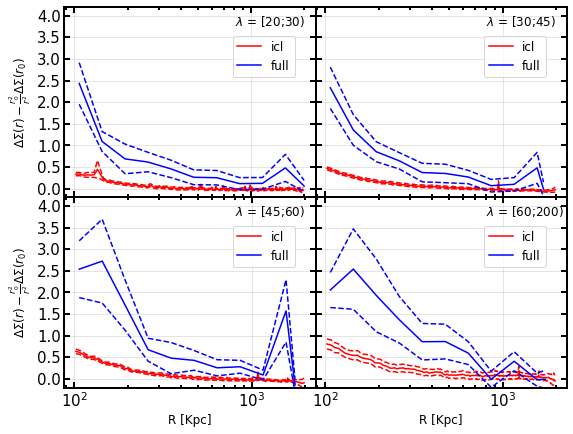

In [18]:
def delta_deltax(rad, delta, r0=200.):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200.
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200.):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200.):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

from scipy.interpolate import interp1d

fig = plt.figure(figsize=(9,7))  

qvalues = []


for i in range(4):
    
    ax = plt.subplot(2,2,i+1)
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid(alpha=0.4)
    
    
    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])
    

    #  ICL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;200)'] 
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    
    ########################################
    mask = r_red > 100. 

    
    
    #  full image
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments_unmasked.txt')
    r_red_1, mea_1, std_1= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    mask_1 = r_red_1 > 100. 
    
    ########################################

    plt.plot(r_red[mask], mea[mask], '-',color='red',label='icl')
    #plt.errorbar(r_red[mask], mea[mask], yerr=np.array(std[mask]), fmt='.', color='red', 
    #             label='full, '+str_ngals[i])
    plt.plot(r_red[mask], mea[mask]+np.array(std[mask]), '--',color='red',label='')
    plt.plot(r_red[mask], mea[mask]-np.array(std[mask]), '--',color='red',label='')
 
    plt.plot(r_red_1[mask_1], mea_1[mask_1], '-',color='blue', label='full')    
    #plt.errorbar(r_red_1[mask_1], mea_1[mask_1], yerr=np.array(std_1[mask_1]), fmt='.', 
    #             color='blue', label='full, '+str_ngals[i])
    plt.plot(r_red_1[mask_1], mea_1[mask_1]+np.array(std_1[mask_1]), '--',color='blue', label='')   
    plt.plot(r_red_1[mask_1], mea_1[mask_1]-np.array(std_1[mask_1]), '--',color='blue', label='')   

    

    
    plt.ylim(-0.2, 4.2)
    #plt.xlim(100, 3000)
    plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
                   bottom='on', top='on', left='on', right ='on')
    plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
                   bottom='on', top='on', left='on', right ='on')
    plt.yticks(fontsize=0)
    plt.xticks(fontsize=0)
    [ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    plt.subplots_adjust(wspace=0, hspace=0)


    plt.legend(bbox_to_anchor=(0.67, 0.85),  loc=2, fontsize=12,borderaxespad=0.,
               numpoints=1,scatterpoints=1)
    plt.annotate(str_ngals[i],
                 xy=(0.68,0.9),xycoords='axes fraction',
                 fontsize=12)
    #plt.annotate('$q$ = %.2f'%(ffactor),
    #             xy=(0.03,0.63),xycoords='axes fraction',
    #             fontsize=12)
    

plt.subplot(2,2,1)  
plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=12)
plt.yticks(fontsize = 15)

plt.subplot(2,2,3)  
plt.xlabel('R [Kpc]', fontsize=12)
plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=12)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.subplot(2,2,4)  
plt.xlabel('R [Kpc]', fontsize=12)
plt.xticks(fontsize = 15)


#plt.savefig(save_dir_rdmp+'paper_figures/'+'icl_wl.png', format='png', dpi=300)
plt.show()

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In

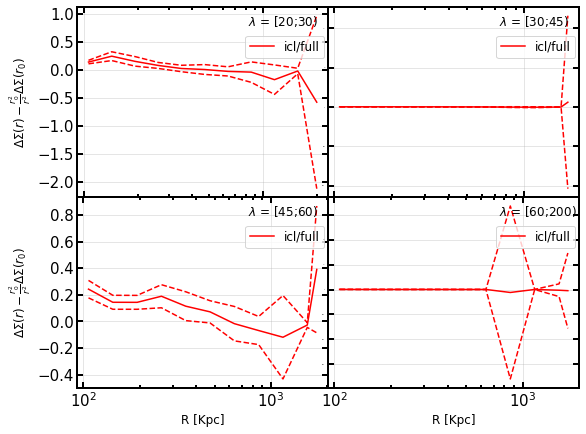

In [19]:
def delta_deltax(rad, delta, r0=200.):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200.
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200.):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200.):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

from scipy.interpolate import interp1d

fig = plt.figure(figsize=(9,7))  

qvalues = []


for i in range(4):
    
    ax = plt.subplot(2,2,i+1)
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid(alpha=0.4)
    
    
    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])
    

    #  ICL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;200)'] 
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    
    ########################################
    
    
    #  full image
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments_unmasked.txt')
    r_red_1, mea_1, std_1= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    
    ########################################
    
    from scipy.interpolate import interp1d
    func=interp1d(r_red, mea, fill_value = 'extrapolate')
    yy_icl=func(r_red_1) 
    func_std=interp1d(r_red, std, fill_value = 'extrapolate')
    yy_icl_std=func_std(r_red_1) 

    #mea_icl = yy_icl[mask]
    #std_icl = yy_icl_std[mask]
    #mea_full = mea_1[mask]
    #std_full = std_1[mask]
    
    import uncertainties as unc  
    import uncertainties.unumpy as unumpy  
    import numpy as np 
    #import nemmen  

    # Defines x and y  
    mask = r_red_1 > 100.   
    xx_arr = r_red_1[mask]
    x = yy_icl[mask]
    y = mea_1[mask]

    # Defines the error arrays, values follow a normal distribution  
    # (method random_normal defined in http://astropython.blogspot.com/2012/04/how-to-generate-array-of-random-numbers.html)  
    errx= yy_icl_std[mask]
    erry= std_1[mask]

    # Defines special arrays holding the values *and* errors  
    x=unumpy.uarray(( x, errx ))  
    y=unumpy.uarray(( y, erry ))  
    
    z=x/y
    mean = unumpy.nominal_values(z)
    
    # Print the propagated error errz  
    std0=unumpy.std_devs(z)
    
    
    plt.plot(xx_arr, mean, '-',color='red',label='icl/full')
    #plt.errorbar(r_red[mask], mea[mask], yerr=np.array(std[mask]), fmt='.', color='red', 
    #             label='full, '+str_ngals[i])
    plt.plot(xx_arr, mean+np.array(std0), '--',color='red',label='')
    plt.plot(xx_arr, mean-np.array(std0), '--',color='red',label='')


    

    
    #plt.ylim(-0.2, 4.2)
    #plt.xlim(100, 3000)
    plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
                   bottom='on', top='on', left='on', right ='on')
    plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
                   bottom='on', top='on', left='on', right ='on')
    plt.yticks(fontsize=0)
    plt.xticks(fontsize=0)
    [ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    plt.subplots_adjust(wspace=0, hspace=0)


    plt.legend(bbox_to_anchor=(0.67, 0.85),  loc=2, fontsize=12,borderaxespad=0.,
               numpoints=1,scatterpoints=1)
    plt.annotate(str_ngals[i],
                 xy=(0.68,0.9),xycoords='axes fraction',
                 fontsize=12)
    #plt.annotate('$q$ = %.2f'%(ffactor),
    #             xy=(0.03,0.63),xycoords='axes fraction',
    #             fontsize=12)
    

plt.subplot(2,2,1)  
plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=12)
plt.yticks(fontsize = 15)

plt.subplot(2,2,3)  
plt.xlabel('R [Kpc]', fontsize=12)
plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=12)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.subplot(2,2,4)  
plt.xlabel('R [Kpc]', fontsize=12)
plt.xticks(fontsize = 15)


#plt.savefig(save_dir_rdmp+'paper_figures/'+'icl_wl.png', format='png', dpi=300)
plt.show()

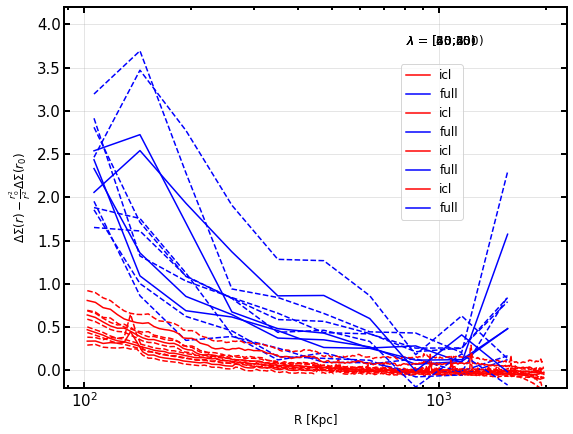

In [37]:
def delta_deltax(rad, delta, r0=200.):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200.
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200.):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200.):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

from scipy.interpolate import interp1d

fig = plt.figure(figsize=(9,7))  
ax = plt.subplot(1,1,1)
plt.xscale('log')
#plt.yscale('log')
plt.grid(alpha=0.4)

qvalues = []


for i in range(4):
    
 
    
    
    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])
    

    #  ICL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;200)'] 
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    
    ########################################
    
    
    #  full image
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments_unmasked.txt')
    r_red_1, mea_1, std_1= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    
    ########################################
    
    mask = r_red > 100.
    mask_1 = r_red_1 > 100.
    
    plt.plot(r_red[mask], mea[mask], '-',color='red',label='icl')
    #plt.errorbar(r_red[mask], mea[mask], yerr=np.array(std[mask]), fmt='.', color='red', 
    #             label='full, '+str_ngals[i])
    plt.plot(r_red[mask], mea[mask]+np.array(std[mask]), '--',color='red',label='')
    plt.plot(r_red[mask], mea[mask]-np.array(std[mask]), '--',color='red',label='')
    
    
 
    plt.plot(r_red_1[mask_1], mea_1[mask_1], '-',color='blue', label='full')    
    #plt.errorbar(r_red_1[mask_1], mea_1[mask_1], yerr=np.array(std_1[mask_1]), fmt='.', 
    #             color='blue', label='full, '+str_ngals[i])
    plt.plot(r_red_1[mask_1], mea_1[mask_1]+np.array(std_1[mask_1]), '--',color='blue', label='')   
    plt.plot(r_red_1[mask_1], mea_1[mask_1]-np.array(std_1[mask_1]), '--',color='blue', label='')   

    

    
    plt.ylim(-0.2, 4.2)
    #plt.xlim(100, 3000)
    plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
                   bottom='on', top='on', left='on', right ='on')
    plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
                   bottom='on', top='on', left='on', right ='on')
    plt.yticks(fontsize=0)
    plt.xticks(fontsize=0)
    [ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    plt.subplots_adjust(wspace=0, hspace=0)


    plt.legend(bbox_to_anchor=(0.67, 0.85),  loc=2, fontsize=12,borderaxespad=0.,
               numpoints=1,scatterpoints=1)
    #plt.annotate(str_ngals[i],
    #             xy=(0.68,0.9),xycoords='axes fraction',
    #             fontsize=12)
    #plt.annotate('$q$ = %.2f'%(ffactor),
    #             xy=(0.03,0.63),xycoords='axes fraction',
    #             fontsize=12)
    


plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=12)
plt.yticks(fontsize = 15)

plt.xlabel('R [Kpc]', fontsize=12)
plt.xticks(fontsize = 15)


#plt.savefig(save_dir_rdmp+'paper_figures/'+'icl_wl.png', format='png', dpi=300)
plt.show()

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:142: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:143: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


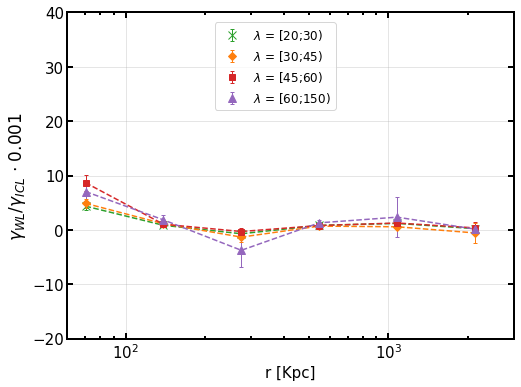

In [24]:
def delta_deltax(rad, delta, r0=200):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

symbols = ['x', 'D', 's','^','o', ]
symbolsize = ['8','5','6','8','8']


from scipy.interpolate import interp1d

fig = plt.figure(figsize=(8,6))  
ax = plt.subplot(1,1,1)
plt.xscale('log')
#plt.yscale('log')
plt.grid(alpha=0.4)

qvalues = []

for i in range(4):
    


    
    ########################################
    #  Weak lensing
    
    # covariance for dsigma
    cov = np.load(wl_prefix+ wl_dir[i]+'cov.npy')
    # covariance for dsigmax
    covx = np.load(wl_prefix+ wl_dir[i]+'covx.npy')
    # DeltaSigma
    dsigma = np.load(wl_prefix+ wl_dir[i]+'dsigma.npy')
    # DeltaSigma_x (cross component)
    dsigmax = np.load(wl_prefix+ wl_dir[i]+'dsigmax.npy')

    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])

    #erro_up = dsigma+np.sqrt(np.diagonal(cov))
    #erro_low = dsigma-np.sqrt(np.diagonal(cov))
    erro_wl = np.sqrt(np.diagonal(cov))
    
    delta_wl = delta_deltax(Rmid*1000, dsigma, r0=200)
    #delta_wl_up = delta_deltax(Rmid*1000, erro_up, r0=200)
    #delta_wl_low = delta_deltax(Rmid*1000, erro_low, r0=200)
    
    
    
    
    ########################################
    #  ICL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;150)']   
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'delta_moments.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]



    up = mea+std
    low = mea-std
    ########################################
    
    func=interp1d(r_red, mea, fill_value = 'extrapolate')
    yy_arr=func(Rmid*1000) 
    
    func_std=interp1d(r_red, std, fill_value = 'extrapolate')
    yy_arr_std=func_std(Rmid*1000) 

    
    
    trustable  = [0,0,0.1, 0.2]
    mask = (Rmid*1000) > trustable[i]
    
    
    ffactor = 1536.0733043172847
    
    
    import uncertainties as unc  
    import uncertainties.unumpy as unumpy  
    import numpy as np 
    #import nemmen  

    xx_arr = (Rmid*1000)[mask]
    # Defines x and y  
    x=yy_arr[mask]
    y=(delta_wl/ffactor)[mask]
    
    # Defines the error arrays, values follow a normal distribution  
    # (method random_normal defined in http://astropython.blogspot.com/2012/04/how-to-generate-array-of-random-numbers.html)  
    errx=np.array(yy_arr_std[mask])
    erry=np.array((erro_wl/ffactor)[mask])

    # Defines special arrays holding the values *and* errors  
    x=unumpy.uarray(( x, errx ))  
    y=unumpy.uarray(( y, erry ))  
    
    z=y/x
    mean = unumpy.nominal_values(z)
    
    # Print the propagated error errz  
    std_frac=unumpy.std_devs(z)
   
    
    #plt.errorbar((Rmid*1000)[mask], mean, yerr=np.array(std_frac),color=colors[i], label=str_ngals[i])
    plt.plot(xx_arr, mean,'--', color=colors[i], label='')
    plt.errorbar(xx_arr, mean, yerr=np.array(std_frac), color=colors[i], fmt=symbols[i],label=str_ngals[i], markersize=symbolsize[i], ecolor=colors[i],capsize=2, elinewidth=1.)
  
    
    
    
    
    plt.ylim(-20, 40)
    plt.xlim(60, 3000)
    plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
                   bottom='on', top='on', left='on', right ='on')
    plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
                   bottom='on', top='on', left='on', right ='on')
    plt.yticks(fontsize=0)
    plt.xticks(fontsize=0)
    [ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.legend(bbox_to_anchor=(0.33, 0.97),  loc=2, fontsize=12,borderaxespad=0.,
               numpoints=1,scatterpoints=1)
    
    #plt.annotate('$q$ = %.2f'%(ffactor),
    #             xy=(0.03,0.63),xycoords='axes fraction',
    #             fontsize=12)
    



plt.ylabel(r'$\gamma_{WL}$/$\gamma_{ICL}$'+' $\cdot$ %.3f'%(1./ffactor), fontsize=17)
plt.xlabel('r [Kpc]', fontsize=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.savefig(save_dir_rdmp+'paper_figures/'+'icl_wl_ratio.png', format='png', dpi=300)
plt.show()

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:143: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:144: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


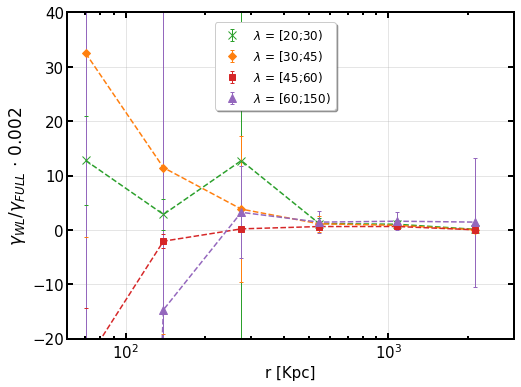

In [26]:
def delta_deltax(rad, delta, r0=200):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

symbols = ['x', 'D', 's','^','o', ]
symbolsize = ['8','5','6','8','8']


from scipy.interpolate import interp1d

fig = plt.figure(figsize=(8,6))  
ax = plt.subplot(1,1,1)
plt.xscale('log')
#plt.yscale('log')
plt.grid(alpha=0.4)

qvalues = []

for i in range(4):
    


    
    ########################################
    #  Weak lensing
    
    # covariance for dsigma
    cov = np.load(wl_prefix+ wl_dir[i]+'cov.npy')
    # covariance for dsigmax
    covx = np.load(wl_prefix+ wl_dir[i]+'covx.npy')
    # DeltaSigma
    dsigma = np.load(wl_prefix+ wl_dir[i]+'dsigma.npy')
    # DeltaSigma_x (cross component)
    dsigmax = np.load(wl_prefix+ wl_dir[i]+'dsigmax.npy')

    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])

    #erro_up = dsigma+np.sqrt(np.diagonal(cov))
    #erro_low = dsigma-np.sqrt(np.diagonal(cov))
    erro_wl = np.sqrt(np.diagonal(cov))
    
    delta_wl = delta_deltax(Rmid*1000, dsigma, r0=200)
    #delta_wl_up = delta_deltax(Rmid*1000, erro_up, r0=200)
    #delta_wl_low = delta_deltax(Rmid*1000, erro_low, r0=200)
    
    
    
    
    ########################################
    #  ICL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;150)']   
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'delta_moments_unmasked.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]



    up = mea+std
    low = mea-std
    ########################################
    
    func=interp1d(r_red, mea, fill_value = 'extrapolate')
    yy_arr=func(Rmid*1000) 
    
    func_std=interp1d(r_red, std, fill_value = 'extrapolate')
    yy_arr_std=func_std(Rmid*1000) 

    
    
    trustable  = [0,0,0.1, 0.2]
    mask = (Rmid*1000) > trustable[i]
    
    
    ffactor = 1536.0733043172847
    ffactor = 415.20
    
    
    import uncertainties as unc  
    import uncertainties.unumpy as unumpy  
    import numpy as np 
    #import nemmen  

    xx_arr = (Rmid*1000)[mask]
    # Defines x and y  
    x=yy_arr[mask]
    y=(delta_wl/ffactor)[mask]
    
    # Defines the error arrays, values follow a normal distribution  
    # (method random_normal defined in http://astropython.blogspot.com/2012/04/how-to-generate-array-of-random-numbers.html)  
    errx=np.array(yy_arr_std[mask])
    erry=np.array((erro_wl/ffactor)[mask])

    # Defines special arrays holding the values *and* errors  
    x=unumpy.uarray(( x, errx ))  
    y=unumpy.uarray(( y, erry ))  
    
    z=y/x
    mean = unumpy.nominal_values(z)
    
    # Print the propagated error errz  
    std_frac=unumpy.std_devs(z)
   
    
    #plt.errorbar((Rmid*1000)[mask], mean, yerr=np.array(std_frac),color=colors[i], label=str_ngals[i])
    plt.plot(xx_arr, mean,'--', color=colors[i], label='')
    plt.errorbar(xx_arr, mean, yerr=np.array(std_frac), color=colors[i], fmt=symbols[i],label=str_ngals[i], markersize=symbolsize[i], ecolor=colors[i],capsize=2, elinewidth=1.)
  
    
    
    
    
    plt.ylim(-20, 40)
    plt.xlim(60, 3000)
    plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
                   bottom='on', top='on', left='on', right ='on')
    plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
                   bottom='on', top='on', left='on', right ='on')
    plt.yticks(fontsize=0)
    plt.xticks(fontsize=0)
    [ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.legend(bbox_to_anchor=(0.33, 0.97),  loc=2, fontsize=12,borderaxespad=0.,
               numpoints=1,scatterpoints=1,frameon=True, shadow=True)
    
    #plt.annotate('$q$ = %.2f'%(ffactor),
    #             xy=(0.03,0.63),xycoords='axes fraction',
    #             fontsize=12)
    



plt.ylabel(r'$\gamma_{WL}$/$\gamma_{FULL}$'+' $\cdot$ %.3f'%(1./ffactor), fontsize=17)
plt.xlabel('r [Kpc]', fontsize=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.savefig(save_dir_rdmp+'paper_figures/'+'full_wl_ratio.png', format='png', dpi=300)
plt.show()

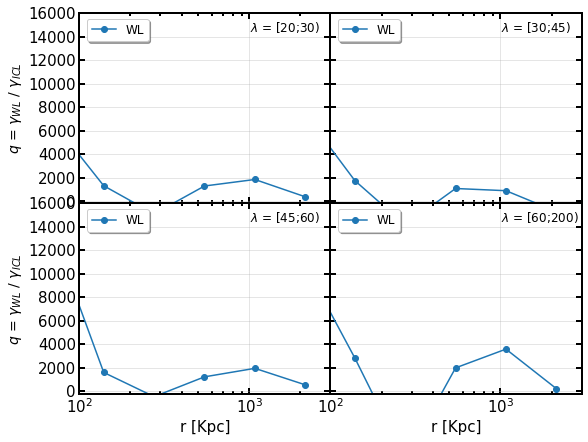

In [23]:
def delta_deltax(rad, delta, r0=200):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

from scipy.interpolate import interp1d

fig = plt.figure(figsize=(9,7))  

for i in range(4):
    
    ax = plt.subplot(2,2,i+1)
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid(alpha=0.4)

    
    ########################################
    #  Weak lensing
    
    # covariance for dsigma
    cov = np.load(wl_prefix+ wl_dir[i]+'cov.npy')
    # covariance for dsigmax
    covx = np.load(wl_prefix+ wl_dir[i]+'covx.npy')
    # DeltaSigma
    dsigma = np.load(wl_prefix+ wl_dir[i]+'dsigma.npy')
    # DeltaSigma_x (cross component)
    dsigmax = np.load(wl_prefix+ wl_dir[i]+'dsigmax.npy')

    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])

    erro_up = dsigma+np.sqrt(np.diagonal(cov))
    erro_low = dsigma-np.sqrt(np.diagonal(cov))
    
    delta_wl = delta_deltax(Rmid*1000, dsigma, r0=200)
    delta_wl_up = delta_deltax(Rmid*1000, erro_up, r0=200)
    delta_wl_low = delta_deltax(Rmid*1000, erro_low, r0=200)
    
    ########################################
    #  ICL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']   
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'delta_moments.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    up = mea+std
    low = mea-std
    ########################################
    
    func=interp1d(r_red, mea, fill_value = 'extrapolate')
    yy_arr=func(Rmid*1000) 
    
    ffactor = np.array(delta_wl/yy_arr)
    
    #plt.errorbar(r_red, mea, yerr=np.array(std), label='ICL')
    plt.plot(Rmid*1000, ffactor, 'o-',label='WL')
    
    
    
    
    plt.ylim(-200, 16000)
    plt.xlim(100, 3000)
    plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
                   bottom='on', top='on', left='on', right ='on')
    plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
                   bottom='on', top='on', left='on', right ='on')
    plt.yticks(fontsize=0)
    plt.xticks(fontsize=0)
    [ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.legend(bbox_to_anchor=(0.03, 0.97),  loc=2, fontsize=12,borderaxespad=0.,
               numpoints=1,scatterpoints=1,frameon=True, shadow=True)
    
    plt.annotate(str_ngals[i],
                 xy=(0.68,0.9),xycoords='axes fraction',
                 fontsize=12)
    #plt.annotate('$q$ = %.2f'%(ffactor),
    #             xy=(0.03,0.59),xycoords='axes fraction',
    #             fontsize=10)
    

plt.subplot(2,2,1)  
plt.ylabel(r'$q$ = $\gamma_{WL}$ / $\gamma_{ICL}$', fontsize=14)
plt.yticks(fontsize = 15)

plt.subplot(2,2,3)  
plt.xlabel('r [Kpc]', fontsize=15)
plt.ylabel(r'$q$ = $\gamma_{WL}$ / $\gamma_{ICL}$', fontsize=14)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.subplot(2,2,4)  
plt.xlabel('r [Kpc]', fontsize=15) 
plt.xticks(fontsize = 15)
plt.show()

[ 6707.36332468  1297.32350062 -1096.35095728  1276.06016279
  1830.95919568   357.59919072]
[ 7481.30176765  1738.57154764 -2040.62503258  1063.72361793
   876.02023753  -893.8728196 ]
[13317.47414988  1600.31779423  -460.97351473  1226.16342183
  1950.03656116   547.17742852]
[10839.22146536  2832.9866681  -5779.82706241  1990.33952864
  3587.36579735   222.85953223]


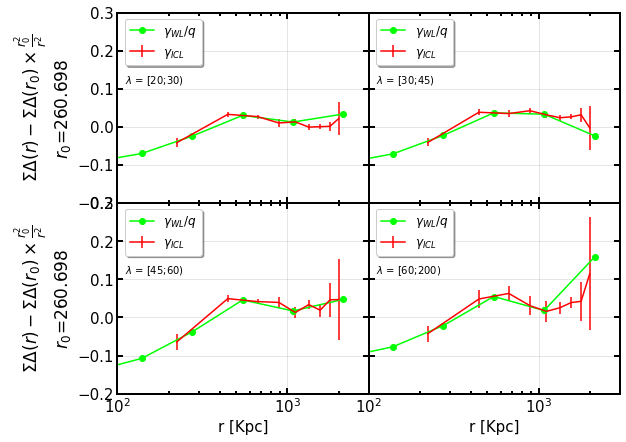

In [24]:
def delta_deltax(rad, delta, r0=200):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

from scipy.interpolate import interp1d

fig = plt.figure(figsize=(9,7))  

for i in range(4):
    
    ax = plt.subplot(2,2,i+1)
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid(alpha=0.4)

    
    ########################################
    #  Weak lensing
    
    # covariance for dsigma
    cov = np.load(wl_prefix+ wl_dir[i]+'cov.npy')
    # covariance for dsigmax
    covx = np.load(wl_prefix+ wl_dir[i]+'covx.npy')
    # DeltaSigma
    dsigma = np.load(wl_prefix+ wl_dir[i]+'dsigma.npy')
    # DeltaSigma_x (cross component)
    dsigmax = np.load(wl_prefix+ wl_dir[i]+'dsigmax.npy')

    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])

    erro_up = dsigma+np.sqrt(np.diagonal(cov))
    erro_low = dsigma-np.sqrt(np.diagonal(cov))
    
    delta_wl = delta_deltax(Rmid*1000, dsigma, r0=200)
    delta_wl_up = delta_deltax(Rmid*1000, erro_up, r0=200)
    delta_wl_low = delta_deltax(Rmid*1000, erro_low, r0=200)
    
    ########################################
    #  ICL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']   
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'delta_moments.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    up = mea+std
    low = mea-std
    ########################################
    
    func=interp1d(r_red, mea, fill_value = 'extrapolate')
    yy_arr=func(Rmid*1000) 
    
    ffactor = np.array(delta_wl/yy_arr)
    print(ffactor)
    
    plt.errorbar(r_red, mea, yerr=np.array(std),color='red', label='$\gamma_{ICL}$')
    plt.plot(Rmid*1000, delta_wl/ffactor, 'o-',color='blue',label='$\gamma_{WL}$/$q$')
    
    
    
    
    plt.ylim(-0.2, 0.3)
    plt.xlim(100, 3000)
    plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
                   bottom='on', top='on', left='on', right ='on')
    plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
                   bottom='on', top='on', left='on', right ='on')
    plt.yticks(fontsize=0)
    plt.xticks(fontsize=0)
    [ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.legend(bbox_to_anchor=(0.03, 0.97),  loc=2, fontsize=12,borderaxespad=0.,
               numpoints=1,scatterpoints=1,frameon=True, shadow=True)
    
    plt.annotate(str_ngals[i],
                 xy=(0.03,0.63),xycoords='axes fraction',
                 fontsize=10)
    #plt.annotate('$q$ = %.2f'%(ffactor),
    #             xy=(0.03,0.59),xycoords='axes fraction',
    #             fontsize=10)
    

plt.subplot(2,2,1)  
#plt.ylabel(r'$\gamma$', fontsize=17)
plt.ylabel(r'$\Sigma \Delta(r) - \Sigma \Delta(r_{0}) \times \frac{r_{0}^{2}}{r^{2}}$'+'\n'+'$r_{0}$=260.698', fontsize=17)
plt.yticks(fontsize = 15)

plt.subplot(2,2,3)  
plt.xlabel('r [Kpc]', fontsize=15)
#plt.ylabel(r'$\gamma$', fontsize=17)
plt.ylabel(r'$\Sigma \Delta(r) - \Sigma \Delta(r_{0}) \times \frac{r_{0}^{2}}{r^{2}}$'+'\n'+'$r_{0}$=260.698', fontsize=17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.subplot(2,2,4)  
plt.xlabel('r [Kpc]', fontsize=15) 
plt.xticks(fontsize = 15)
plt.show()

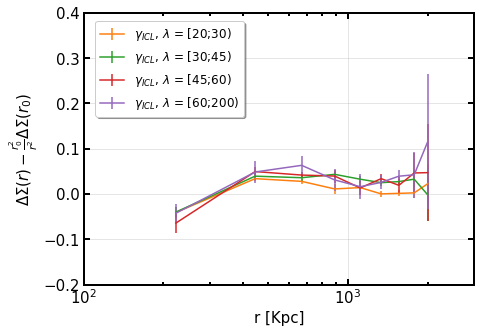

In [25]:
def delta_deltax(rad, delta, r0=200):
    func=interp1d(rad, delta, fill_value = 'extrapolate')
    deltax=func(r0)     
    return delta - deltax * (r0**2/rad**2)

def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    return_arr = np.zeros(len(dat1))
    dat=dat1
    xx_temp=radius
    yy_temp=dat*xx_temp
    yy_temp=np.insert(yy_temp, 0, yy_temp[0])
    xx_temp=np.insert(xx_temp, 0, 0) # r0=200
    for kk in range(len(dat1)):
        return_arr[kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])
    return return_arr

def first_delta_icl(rad, sigma, r0=200):   
    integr = integrate_flux(rad, sigma)    
    return (2/(rad**2)) * integr - sigma

'''
def delta_delta_icl(rad, sigma, r0=200):
    func=interp1d(rad, sigma, fill_value = 'extrapolate')
    sigma0=func(r0)         
    rmask=(np.array(rad)<r0)
    rad = rad[rmask]
    sigma = sigma[rmask]    
    integr = integrate_flux(rad, sigma)    
    return rad , (2/(rad**2)) * integr - (1/(rad**2)) * ( (rad**2)*sigma - (r0**2) - sigma0 ) 
'''

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']

wl_prefix = '/home/hillysson/diffuselight_dataproc/dlight/wl_profiles/'
wl_dir = ['dsigma_ICL_lam20-30/',
          'dsigma_ICL_lam30-45/',
          'dsigma_ICL_lam45-60/',
          'dsigma_ICL_lam60-200/']

from scipy.interpolate import interp1d

fig = plt.figure(figsize=(7,5))  
ax = plt.subplot()
plt.xscale('log')
#plt.yscale('log')
plt.grid(alpha=0.4)

for i in range(4):
    


    
    ########################################
    #  Weak lensing
    
    # covariance for dsigma
    cov = np.load(wl_prefix+ wl_dir[i]+'cov.npy')
    # covariance for dsigmax
    covx = np.load(wl_prefix+ wl_dir[i]+'covx.npy')
    # DeltaSigma
    dsigma = np.load(wl_prefix+ wl_dir[i]+'dsigma.npy')
    # DeltaSigma_x (cross component)
    dsigmax = np.load(wl_prefix+ wl_dir[i]+'dsigmax.npy')

    radii = np.logspace(np.log10(0.05),np.log10(3.0),7)
    Rmid = np.sqrt(radii[1:]*radii[:-1])

    erro_up = dsigma+np.sqrt(np.diagonal(cov))
    erro_low = dsigma-np.sqrt(np.diagonal(cov))
    
    delta_wl = delta_deltax(Rmid*1000, dsigma, r0=200)
    delta_wl_up = delta_deltax(Rmid*1000, erro_up, r0=200)
    delta_wl_low = delta_deltax(Rmid*1000, erro_low, r0=200)
    
    ########################################
    #  ICL
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;200)']   
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'delta_moments.txt')
    r_red, mea, std= jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    up = mea+std
    low = mea-std
    ########################################
    
    func=interp1d(r_red, mea, fill_value = 'extrapolate')
    yy_arr=func(Rmid*1000) 
    
    ffactor = np.array(delta_wl/yy_arr)
    
    plt.errorbar(r_red, mea, yerr=np.array(std), color=colors[i],label='$\gamma_{ICL}$, '+str_ngals[i])
    #plt.plot(Rmid*1000, delta_wl/ffactor, 'o-',label='$\gamma_{WL}$/$q$')
    
    
    
    
plt.ylim(-0.2, 0.4)
plt.xlim(100, 3000)
plt.xlabel('r [Kpc]', fontsize=15)
plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=15)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)

plt.legend(bbox_to_anchor=(0.03, 0.97),  loc=2, fontsize=12,borderaxespad=0.,
           numpoints=1,scatterpoints=1,frameon=True, shadow=True)


plt.show()

In [ ]:
import sympy as sym
x = sym.Symbol('x')

In [ ]:
sym.diff(x**5)

In [ ]:
5*5**4

In [ ]:
from sympy import *
import numpy as np


x = Symbol('x') # x = np.log10(lambda_)
y = x**3 + 1    # y = np.log10(flux)
yprime = y.diff(x)
f = lambdify(x, yprime, 'numpy')
f(3)


In [ ]:
p = np.poly1d([1, 2, 1])
print(p)

In [ ]:
q = p.deriv()
print(q)

In [ ]:
q(5)